# 04. NLP Analysis (Weeks 6-7)

## The Semantic Layer

This notebook complements the network analysis by examining the textual content of item descriptions and dialogue.

### Course Concepts Applied
1.  **Week 6: Text Analysis (TF-IDF)**
    -   **Method:** Term Frequency-Inverse Document Frequency.
    -   **Application:** Extracting distinct vocabularies for the "Int" vs. "Faith" factions.
2.  **Week 7: Sentiment Analysis**
    -   **Method:** Lexical Sentiment / Keyword Counting.
    -   **Application:** Quantifying the "Tragedy of Commerce" by counting death-related terms in merchant descriptions.

In [1]:
from pathlib import Path

import math
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer

CANDIDATES = [Path.cwd(), Path.cwd().parent, Path.cwd().parents[1]]
PROJECT_ROOT = None
for candidate in CANDIDATES:
    if (candidate / "data").exists():
        PROJECT_ROOT = candidate.resolve()
        break
if PROJECT_ROOT is None:
    raise RuntimeError("Project root not found.")

nodes_path = PROJECT_ROOT / "data" / "processed" / "nodes.csv"
node_df = pd.read_csv(nodes_path)
node_df['description'] = node_df['description'].fillna('')
node_df.head(2)

,node_id,node_type,name,description,int_scaling,faith_scaling,bell_bearing_source,merchant_flag,faction_tags,raw_endpoint,extra_json
0,17f695abef9l0i1ujzrup5y0z7rw6,boss,Abductor Virgins,Deadly mechanical constructs who wield massive...,False,False,False,False,Volcano Manor,bosses,"{""image"": null, ""region"": ""Mount Gelmir"", ""loc..."
1,17f69b4ba0al0i1uk6s98t1nbtxunt,boss,"Alecto, Black Knife Ringleader",Remarkably agile and aggressive warrior. Dange...,False,False,False,False,NaN,bosses,"{""image"": ""https://eldenring.fanapis.com/image..."


In [2]:
# Parse faction tags from nodes.csv (pipe-delimited strings)
def split_tags(value: str | float | None) -> list[str]:
    if isinstance(value, str) and value.strip():
        return [segment.strip() for segment in value.split("|") if segment.strip()]
    return []

if "faction_tags" in node_df.columns:
    node_df["faction_tags"] = node_df.get("faction_tags", "").apply(split_tags)
else:
    node_df["faction_tags"] = [[] for _ in range(len(node_df))]

node_df.head(2)

,node_id,node_type,name,description,int_scaling,faith_scaling,bell_bearing_source,merchant_flag,faction_tags,raw_endpoint,extra_json
0,17f695abef9l0i1ujzrup5y0z7rw6,boss,Abductor Virgins,Deadly mechanical constructs who wield massive...,False,False,False,False,[Volcano Manor],bosses,"{""image"": null, ""region"": ""Mount Gelmir"", ""loc..."
1,17f69b4ba0al0i1uk6s98t1nbtxunt,boss,"Alecto, Black Knife Ringleader",Remarkably agile and aggressive warrior. Dange...,False,False,False,False,[],bosses,"{""image"": ""https://eldenring.fanapis.com/image..."


In [3]:
def top_terms(mask: pd.Series, label: str, k: int = 20):
    corpus = node_df.loc[mask, 'description']
    vectorizer = TfidfVectorizer(max_features=2000, stop_words='english')
    matrix = vectorizer.fit_transform(corpus)
    scores = matrix.mean(axis=0).A1
    vocab = np.array(vectorizer.get_feature_names_out())
    order = scores.argsort()[::-1][:k]
    return pd.DataFrame({
        'term': vocab[order],
        'mean_tfidf': scores[order],
        'faction': label
    })

int_terms = top_terms(node_df['int_scaling'], 'intelligence')
faith_terms = top_terms(node_df['faith_scaling'], 'faith')
pd.concat([int_terms, faith_terms], ignore_index=True)

,term,mean_tfidf,faction
0,incantation,0.078269,intelligence
1,incantations,0.066236,intelligence
2,dragon,0.051529,intelligence
3,glintstone,0.044445,intelligence
4,fingers,0.044030,intelligence
5,ancient,0.043612,intelligence
6,communion,0.036402,intelligence
7,erdtree,0.036146,intelligence
8,faithful,0.029596,intelligence
9,superior,0.028311,intelligence


### Week 6: TF-IDF & Vocabulary Mining
We use **TF-IDF (Term Frequency-Inverse Document Frequency)** to identify the most characteristic words for the "Intelligence" and "Faith" factions. This allows us to see if the structural schism is mirrored by a semantic one.

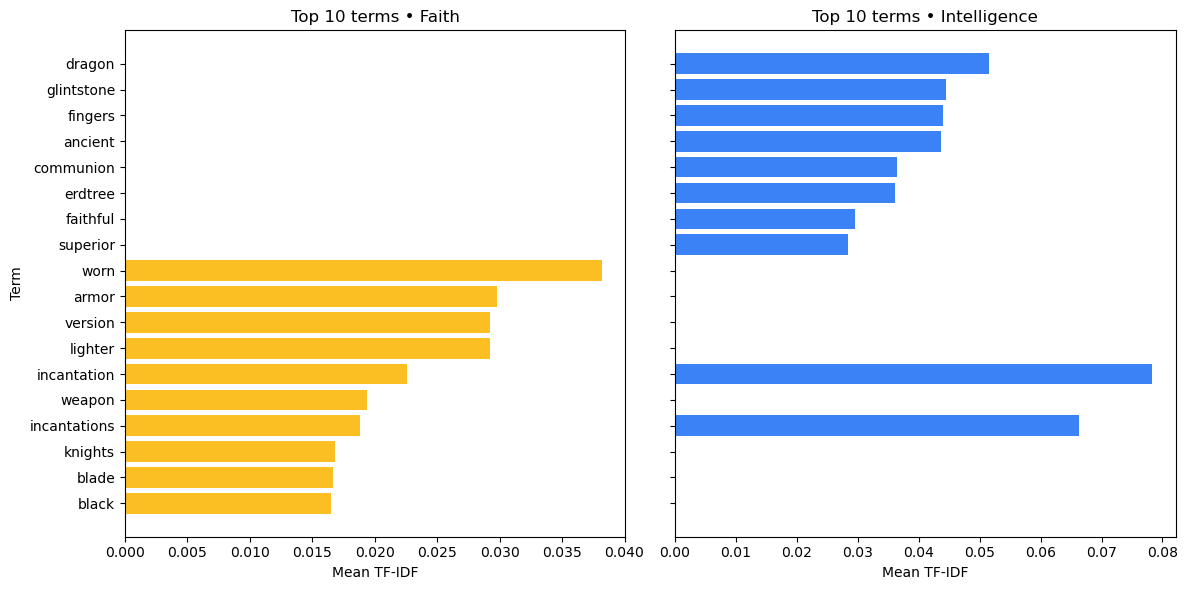

In [4]:
import matplotlib.pyplot as plt

TOP_K = 10
term_plot_df = (
    pd.concat([int_terms, faith_terms], ignore_index=True)
    .groupby(["faction", "term"], as_index=False)["mean_tfidf"].mean()
)
plot_data = term_plot_df.sort_values(["faction", "mean_tfidf"], ascending=[True, False])
plot_data = plot_data.groupby("faction").head(TOP_K)

fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharey=True)
color_map = {"intelligence": "#3b82f6", "faith": "#fbbf24"}

for ax, (faction, subset) in zip(axes, plot_data.groupby("faction")):
    subset = subset.sort_values("mean_tfidf")
    ax.barh(subset["term"], subset["mean_tfidf"], color=color_map.get(faction, "gray"))
    ax.set_title(f"Top {TOP_K} terms • {faction.title()}")
    ax.set_xlabel("Mean TF-IDF")

axes[0].set_ylabel("Term")
plt.tight_layout()
plt.show()

In [6]:
DEATH_LEXICON = {"death", "die", "dead", "slain", "murder", "corpse", "tragedy", "spirit", "ghost"}
def fate_score(text: str) -> int:
    text_lower = text.casefold()
    return sum(token in text_lower for token in DEATH_LEXICON)

node_df['fate_score'] = node_df['description'].apply(fate_score)
merchant_scores = node_df.groupby('merchant_flag')['fate_score'].mean().rename({True: 'merchant', False: 'non_merchant'})
merchant_scores

merchant_flag
non_merchant    0.13369
merchant        0.00000
Name: fate_score, dtype: float64

### Week 7: Sentiment Analysis (Lexical)
We perform a targeted sentiment analysis using a custom "Death Lexicon". We hypothesize that merchants (who drop Bell Bearings) will have descriptions richer in tragic/death-related terminology than non-merchants.

In [7]:
fate_items = node_df[node_df['bell_bearing_source'] | node_df['name'].str.contains('Bell Bearing', case=False, na=False)]
top_fate = fate_items.sort_values('fate_score', ascending=False)[['name', 'node_type', 'description', 'fate_score']].head(15)
top_fate

,name,node_type,description,fate_score
12,Bell Bearing Hunter,boss,"Menacing and slow-paced, it wields a large, re...",0
1717,Marais Executioner's Sword,weapon,"Storied sword of House Marais, the family of e...",0


### Visualizing the Semantics (Word Clouds)
We generate word clouds to visually compare the dominant vocabulary of the three key groups. This serves as a qualitative check on our "Sentiment" and "Schism" hypotheses.
1.  **Intelligence:** Expected to feature "glintstone", "star", "crystal".
2.  **Faith:** Expected to feature "gold", "erdtree", "light".
3.  **Fate (Bell Bearings):** Expected to feature terms related to the "Tragedy of Commerce" (death, offering, husk).

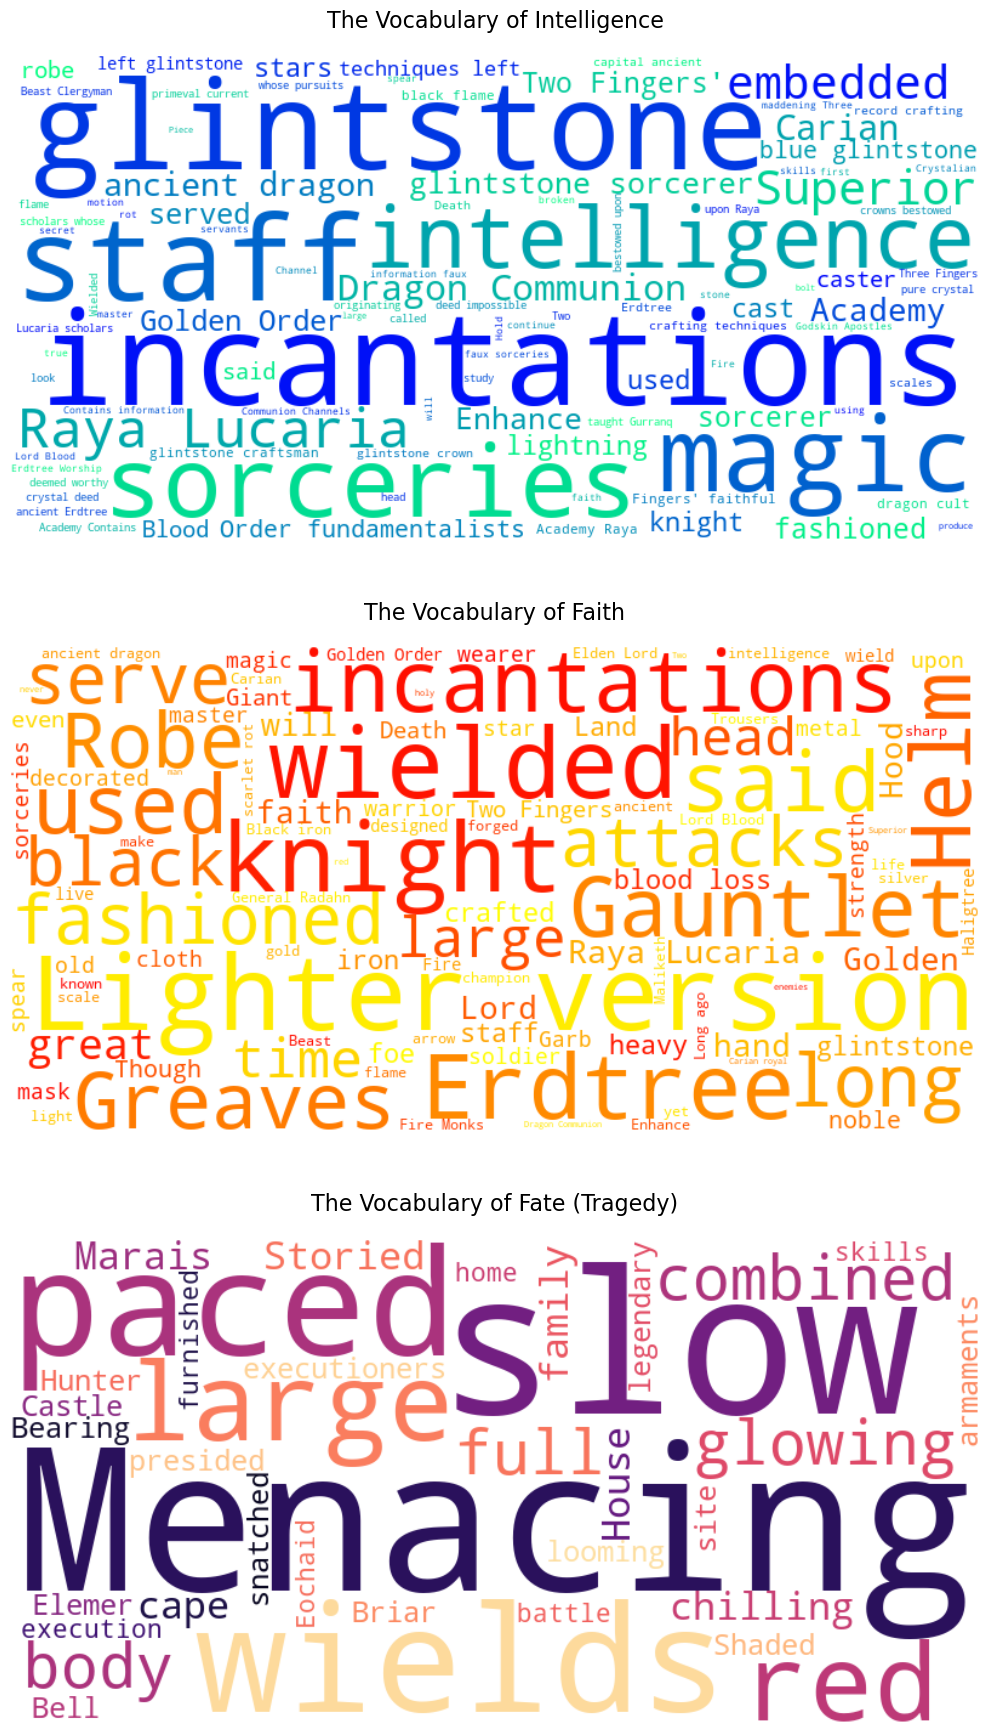

: 

In [ ]:
try:
    from wordcloud import WordCloud, STOPWORDS
except ImportError:
    import sys
    !{sys.executable} -m pip install wordcloud
    from wordcloud import WordCloud, STOPWORDS

import matplotlib.pyplot as plt

# Define custom stopwords to remove generic game terms and focus on lore
custom_stopwords = set(STOPWORDS)
generic_game_terms = {
    "worn", "armor", "weapon", "incantation", "shield", "talisman", "item",
    "effect", "skill", "fp", "cost", "attack", "power", "damage", "negation",
    "guard", "boost", "increases", "attributes", "required", "scaling",
    "passive", "use", "equipped", "equipping", "sorcery", "spell", "consumable",
    "material", "upgrade", "ash", "war", "part", "set", "made", "found",
    # User requested removals:
    "one", "blade", "sword", "greatsword", "curved", "straight", "thrusting"
}
custom_stopwords.update(generic_game_terms)

def create_wordcloud(text, title, ax, cmap='viridis'):
    # Generate word cloud with custom stopwords
    # collocations=True (default) helps find bigrams like "Golden Order" or "Two Fingers"
    wc = WordCloud(width=800, height=400, background_color='white', 
                   colormap=cmap, max_words=100, stopwords=custom_stopwords,
                   collocations=True, min_word_length=3).generate(text)
    ax.imshow(wc, interpolation='bilinear')
    ax.axis('off')
    ax.set_title(title, fontsize=16, pad=20)

fig, axes = plt.subplots(3, 1, figsize=(10, 18))

# 1. Intelligence Word Cloud (Blue/Cool tones)
int_text = " ".join(node_df[node_df['int_scaling']]['description'].astype(str))
create_wordcloud(int_text, "The Vocabulary of Intelligence", axes[0], cmap='winter')

# 2. Faith Word Cloud (Gold/Warm tones)
faith_text = " ".join(node_df[node_df['faith_scaling']]['description'].astype(str))
create_wordcloud(faith_text, "The Vocabulary of Faith", axes[1], cmap='autumn')

# 3. Fate/Tragedy Word Cloud (Dark/Magma tones)
# We use the 'fate_items' dataframe defined in the previous cell
fate_text = " ".join(fate_items['description'].astype(str))
create_wordcloud(fate_text, "The Vocabulary of Fate (Tragedy)", axes[2], cmap='magma')

plt.tight_layout()
plt.show()

### Faction Word Clouds (Lore Focused)
Using the auto-detected faction tags (Golden Order, Carian Royalty, etc.), we aggregate every description tied to each group and render new word clouds. This filters out generic gear terminology and surfaces lore-heavy phrases for each faction.

NameError: name 'create_wordcloud' is not defined

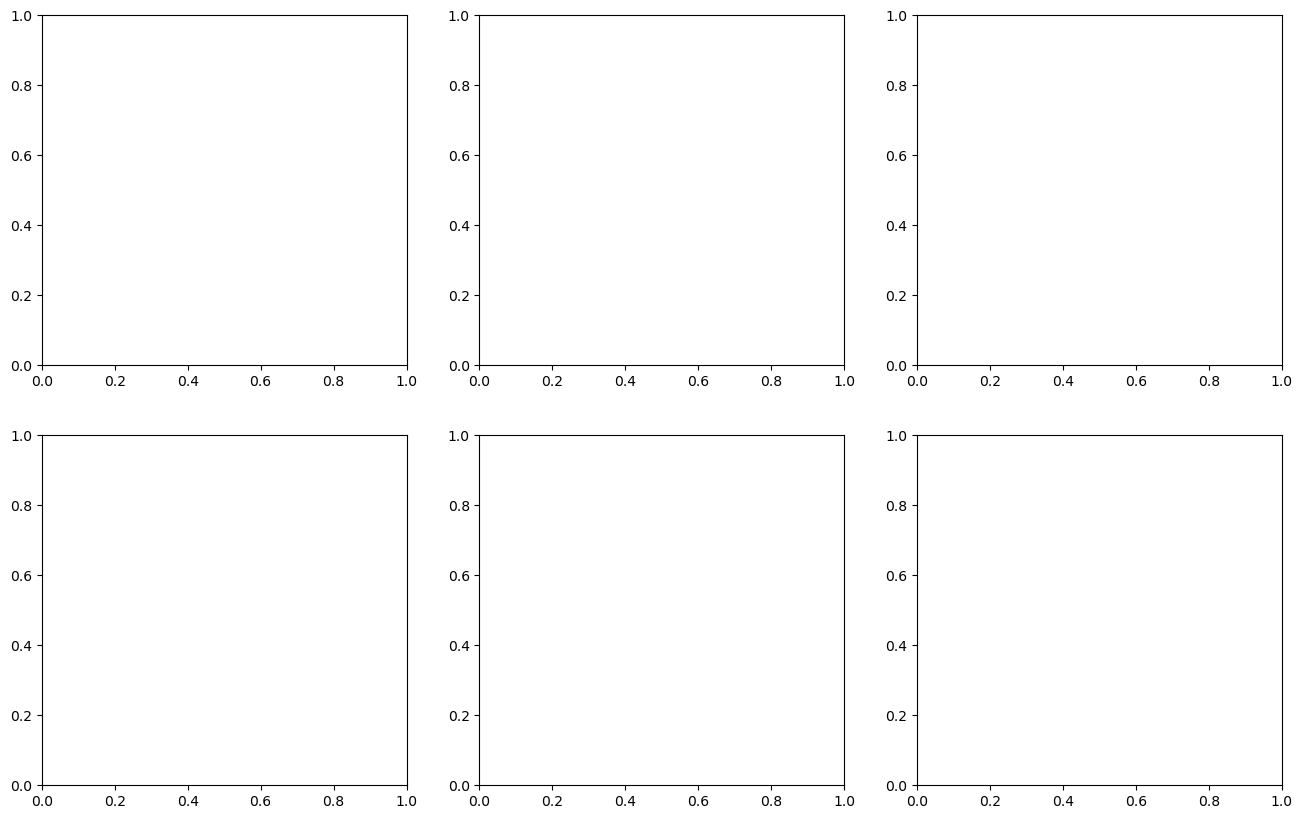

In [5]:
faction_long = (
    node_df[["description", "faction_tags", "name"]]
    .explode("faction_tags")
    .rename(columns={"faction_tags": "faction"})
)
faction_long = faction_long.dropna(subset=["faction"])

if faction_long.empty:
    print("No faction tags detected. Re-run 02_graph_construction.ipynb with the latest pipeline.")
else:
    # Combine descriptions per faction
    faction_corpora = (
        faction_long.groupby("faction")["description"]
        .apply(lambda s: " ".join(s.astype(str)))
        .to_dict()
    )
    # Focus on the six factions with the largest corpora
    target_factions = sorted(
        faction_corpora.keys(),
        key=lambda key: len(faction_corpora[key]),
        reverse=True,
    )[:6]

    cols = 3
    rows = math.ceil(len(target_factions) / cols)
    fig, axes = plt.subplots(rows, cols, figsize=(16, 5 * rows))
    axes = axes.flatten()
    palette = ["winter", "autumn", "magma", "viridis", "plasma", "cividis"]

    for idx, faction in enumerate(target_factions):
        text = faction_corpora.get(faction, "")
        if not text.strip():
            axes[idx].axis('off')
            axes[idx].set_title(f"{faction} (no text)")
            continue
        cmap = palette[idx % len(palette)]
        create_wordcloud(text, f"Faction Vocabulary • {faction}", axes[idx], cmap=cmap)

    # Hide any unused subplots
    for ax in axes[len(target_factions):]:
        ax.axis('off')

    plt.tight_layout()
    plt.show()